In [11]:
import argparse, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import register_data_args, load_data
from dgl.data import BitcoinOTC
import datetime
from dgl.nn.pytorch import GraphConv
import time
from sklearn.metrics import f1_score
import os
import json
from collections import defaultdict, Counter
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import networkx as nx

## Hyperparams

In [15]:
node_dim = 256
n_layers = 2
dropout = 0.2
learning_rate = 0.01
wt_decay = 5e-4
stpsize = 15
n_epochs = 10
out_path = '../btc_static/'
self_loop = True
data_path = '/scratch/rj1408/dynamic_nn/soc-sign-bitcoinotc.csv'

In [16]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    device = 'cuda'
else:
    device = 'cpu'

## Data preparation

In [17]:
def removeSelfEdges(edgeList, colFrom, colTo):
    mask = edgeList[:, colFrom] - edgeList[:, colTo] != 0
    edgeList = edgeList[mask]
    return edgeList

In [18]:
#Loading 
graphs = []

data  = np.loadtxt(data_path, delimiter=',').astype(np.int64)
data[:, 0:2] = data[:, 0:2] - data[:, 0:2].min()
data = removeSelfEdges(data, 0, 1)
num_nodes = data[:, 0:2].max() - data[:, 0:2].min() + 1
delta = datetime.timedelta(days=14).total_seconds()
time_index = np.around(
    (data[:, 3] - data[:, 3].min())/delta).astype(np.int64)

prevind = 0
for i in range(time_index.max()):
    g = DGLGraph()
    g.add_nodes(num_nodes)
    row_mask = time_index <= i
    edges = data[row_mask][:, 0:2]
    rate = data[row_mask][:, 2]
    diffmask = np.arange(len(edges)) >= prevind
    g.add_edges(edges[:, 0], edges[:, 1])
    g.edata['feat'] = torch.FloatTensor(rate.reshape(-1, 1))
    g.edata['diff'] = diffmask
    g.ndata['feat'] = torch.zeros(num_nodes, node_dim)
    
    if self_loop == True:
        g.add_edges(g.nodes(), g.nodes())
        
    selfedgemask = np.zeros(g.number_of_edges(), dtype = bool)
    selfedgemask[-g.number_of_nodes():] = True
    g.edata['self_edge'] = selfedgemask
    
    graphs.append(g)
    prevind = len(edges)
    
train_graph = graphs[94]
valid_graphs = graphs[95:109]
test_graphs = graphs[109:]

## Model definition

In [19]:
class GCN(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GraphConv(in_feats, n_hidden, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GraphConv(n_hidden, n_hidden, activation=activation))
        # output layer
        self.distrlayer = nn.Linear(2 * n_hidden, 64, bias = True)
        self.nonlinear = nn.ReLU()
        self.outlayer = nn.Linear(64, 1, bias = True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, features, g):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(g, h)
        srcfeatures = torch.stack(list(map(lambda nd: h[nd], g.all_edges()[0])))
        destfeatures = torch.stack(list(map(lambda nd: h[nd], g.all_edges()[1])))
        edgefeatures = torch.cat((srcfeatures, destfeatures), dim = 1)
        outputs = self.nonlinear(self.distrlayer(edgefeatures))
        outputs = self.outlayer(outputs)
        outputs = 20*torch.sigmoid(outputs) - 10
        return outputs

## Training loop

In [20]:
def evaluate_loss(model, criterion, device, valid_graphs):
    model.eval()
    
    epoch_loss = 0
    num_samples = 0
    
    #validation phase
    with torch.set_grad_enabled(False):
        for val_graph in valid_graphs:
            feat = val_graph.ndata['feat'].to(device)
            outputs = model(feat, val_graph)
            labels = val_graph.edata['feat']
            labels = labels.to(device)
            outputs = outputs[val_graph.edata['diff']]
            labels = labels[val_graph.edata['diff']]
            num_samples += labels.shape[0] 
            loss = criterion(outputs, labels)
            epoch_loss += (loss.item()* labels.shape[0])
    
    return epoch_loss/num_samples

In [21]:
def evaluate_f1(model, criterion, device, valid_graphs):
    model.eval()
    
    #validation phase
    with torch.set_grad_enabled(False):
        for i, val_graph in enumerate(valid_graphs):
            feats = val_graph.ndata['feat'].to(device)
            outputs = model(feats, val_graph)
            labels = val_graph.edata['feat']
            labels = labels.to(device)
            outputs = outputs[val_graph.edata['diff']]
            outputs = outputs.round().long()
            labels = labels[val_graph.edata['diff']]
            
            if i == 0:
                all_outputs = outputs
                all_labels = labels
            else:
                all_outputs = torch.cat((all_outputs, outputs), dim = 0)
                all_labels = torch.cat((all_labels, labels), dim = 0)
        all_outputs = all_outputs.detach().cpu().numpy()
        all_labels = all_labels.detach().cpu().numpy()
        f1score = f1_score(all_labels, all_outputs, average='micro')
    return f1score

In [22]:
#Code for supervised training
def train_model(model, criterion, optimizer, scheduler, device, checkpoint_path, hyperparams, num_epochs=25):
    metrics_dict = {}
    metrics_dict["train"] = {}
    metrics_dict["valid"] = {}
    metrics_dict["train"]["loss"] = {}
    metrics_dict["train"]["loss"]["epochwise"] = []
    metrics_dict["valid"]["loss"] = {}
    metrics_dict["valid"]["loss"]["epochwise"] = []
        
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 9999999999999999

    for epoch in range(num_epochs):
        print('Epoch {}/{} \n'.format(epoch, num_epochs - 1))
        print('-' * 10)
        print('\n')
        
        
        #train phase
        scheduler.step()
        model.train() 
        optimizer.zero_grad()
        # forward
        # track history if only in train
        forward_start_time  = time.time()
        with torch.set_grad_enabled(True):
            feats = train_graph.ndata['feat'].to(device)
            outputs = model(feats, train_graph)
            labels = train_graph.edata['feat']
            labels = labels.to(device)
            outputs = outputs[~train_graph.edata['self_edge']]
            labels = labels[~train_graph.edata['self_edge']]
            loss = criterion(outputs, labels)
            epoch_loss = loss.item()
            loss.backward()
            optimizer.step()
        forward_time = time.time() - forward_start_time
        
        print('Train Loss: {:.4f} \n'.format(epoch_loss))
        metrics_dict["train"]["loss"]["epochwise"].append(epoch_loss)
        
        #validation phase
        val_epoch_loss = evaluate_loss(model, criterion, device, valid_graphs)
        print('Validation Loss: {:.4f} \n'.format(val_epoch_loss))
        metrics_dict["valid"]["loss"]["epochwise"].append(val_epoch_loss)
        
        # deep copy the model
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'full_metrics': metrics_dict,
        'hyperparams': hyperparams
        }, '%s/net_epoch_%d.pth' % (checkpoint_path, epoch))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s \n'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f} \n'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
 # create GCN model
model = GCN(node_dim, node_dim, n_layers, F.relu, dropout)
model.to(device)
criterion = nn.MSELoss()
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=learning_rate, weight_decay = wt_decay)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=stpsize, gamma=0.1)
hyper_params = {'node_dim' : node_dim,
    'n_layers' : n_layers,
    'dropout' : dropout,
    'wt_decay' : wt_decay }

bst_model = train_model(model, criterion, optimizer, exp_lr_scheduler, device, out_path, hyper_params, n_epochs)

Epoch 0/9 

----------




/home/raghav/anaconda3/envs/dgl_env/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


# Evaluation and Analysis

In [23]:
def load_graphs(node_dim, data_path, self_loop):
    graphs = []

    data  = np.loadtxt(data_path, delimiter=',').astype(np.int64)
    data[:, 0:2] = data[:, 0:2] - data[:, 0:2].min()
    data = removeSelfEdges(data, 0, 1)
    num_nodes = data[:, 0:2].max() - data[:, 0:2].min() + 1
    delta = datetime.timedelta(days=14).total_seconds()
    time_index = np.around(
        (data[:, 3] - data[:, 3].min())/delta).astype(np.int64)

    prevind = 0
    for i in range(time_index.max()):
        g = DGLGraph()
        g.add_nodes(num_nodes)
        row_mask = time_index <= i
        edges = data[row_mask][:, 0:2]
        rate = data[row_mask][:, 2]
        diffmask = np.arange(len(edges)) >= prevind
        g.add_edges(edges[:, 0], edges[:, 1])
        g.edata['feat'] = torch.FloatTensor(rate.reshape(-1, 1))
        g.edata['diff'] = diffmask
        g.ndata['feat'] = torch.zeros(num_nodes, node_dim)

        if self_loop == True:
            g.add_edges(g.nodes(), g.nodes())

        selfedgemask = np.zeros(g.number_of_edges(), dtype = bool)
        selfedgemask[-g.number_of_nodes():] = True
        g.edata['self_edge'] = selfedgemask

        graphs.append(g)
        prevind = len(edges)

    train_graph = graphs[94]
    valid_graphs = graphs[95:109]
    test_graphs = graphs[109:]
    return train_graph, valid_graphs, test_graphs

def evaluate_loss(modelpath, device):
     # create GCN model
    checkpoint = torch.load(modelpath, map_location=device)
    return checkpoint['full_metrics']['valid']['loss'][-1]

def load_and_evaluate_f1(modelpath, device, data_path, self_loop):
     # create GCN model
    checkpoint = torch.load(modelpath, map_location=device)
    hyperdic = checkpoint['hyperparams']
    node_dim = hyperdic['node_dim']
    n_layers = hyperdic['n_layers']
    dropout = hyperdic['dropout']
    wt_decay = hyperdic['wt_decay']
    model = GCN(node_dim, node_dim, n_layers, F.relu, dropout)
    model.to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    criterion = nn.MSELoss()
    
    test_graph = load_graphs(node_dim, data_path, self_loop)[2]
    return evaluate_f1(model, criterion, device, test_graph)

def load_and_evaluate_loss(modelpath, device, data_path, self_loop):
     # create GCN model
    checkpoint = torch.load(modelpath, map_location=device)
    hyperdic = checkpoint['hyperparams']
    node_dim = hyperdic['node_dim']
    n_layers = hyperdic['n_layers']
    dropout = hyperdic['dropout']
    wt_decay = hyperdic['wt_decay']
    model = GCN(node_dim, node_dim, n_layers, F.relu, dropout)
    model.to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    criterion = nn.MSELoss()
    
    test_graph = load_graphs(node_dim, data_path, self_loop)[2]
    return evaluate_loss(model, criterion, device, test_graph)

In [9]:
#find best model
allModelsDir = '/scratch/rj1408/dynamic_nn/models/static_gcn/btcotc/'
data_path = '/scratch/rj1408/dynamic_nn/soc-sign-bitcoinotc.csv'
onlysubfolds = [f for f in listdir(allModelsDir) if not isfile(join(allModelsDir, f))]

lossdict = {}
bstloss = 99999999
bstmodelpath = ''

for subfold in onlysubfolds:
    files = list(filter(lambda f: f.endswith('.pth'), listdir(os.path.join(allModelsDir, subfold))))
    losses = list(map(lambda fil: evaluate_loss(os.path.join(allModelsDir, subfold, fil), device), files))
    minind = np.argmin(losses)
    lossdict[subfold] = (losses[minind], files[minind])
    
    if losses[minind] < bstloss:
        bstloss = losses[minind]
        bstmodelpath = os.path.join(allModelsDir, subfold, files[minind])

In [10]:
lossdict

{'3layers': (13.002268663406372, 'net_epoch_17.pth'),
 '6wtdecay': (13.002610714231219, 'net_epoch_12.pth'),
 'def': (13.002296477726528, 'net_epoch_12.pth'),
 '3wtdecay': (13.002485783985684, 'net_epoch_2.pth'),
 'nodedim512': (13.002256241117205, 'net_epoch_15.pth'),
 '4layers': (13.002257837840489, 'net_epoch_12.pth'),
 'nodedim128': (13.002747981480189, 'net_epoch_16.pth'),
 'p3drpout': (13.003172961916242, 'net_epoch_13.pth'),
 '5wtdecay': (13.006588323048183, 'net_epoch_12.pth'),
 'p4drpout': (13.00229760987418, 'net_epoch_17.pth'),
 '5layers': (13.002393187114171, 'net_epoch_23.pth'),
 '2wtdecay': (13.003288143430437, 'net_epoch_14.pth')}

In [ ]:
#find best amongs all configs
print("Finding best model from validation set")
lis = list(lossdict.items())
modlis = np.array(list(map(lambda ele: ele[1][0], lis)))
minind = np.argmin(modlis)
bestmodel = os.path.join(allModelsDir, lis[minind][0], lis[minind][1][1])
print("Min loss: ", lis[minind][1][0])
print("Best config: ", lis[minind][0])

#Get testmetrics
print("Getting test scores")
print(load_and_evaluate_f1(bestmodel, device, data_path, True))

In [24]:
basicmodel = os.path.join(allModelsDir, 'nodedim128',  'net_epoch_16.pth')

#Get testmetrics
print("Getting test f1 score")
print(load_and_evaluate_f1(basicmodel, device, data_path, True))

print("Getting test loss")
print(load_and_evaluate_loss(basicmodel, device, data_path, True))

Getting test f1 score
0.516256157635468
Getting test loss
10.318315746925148


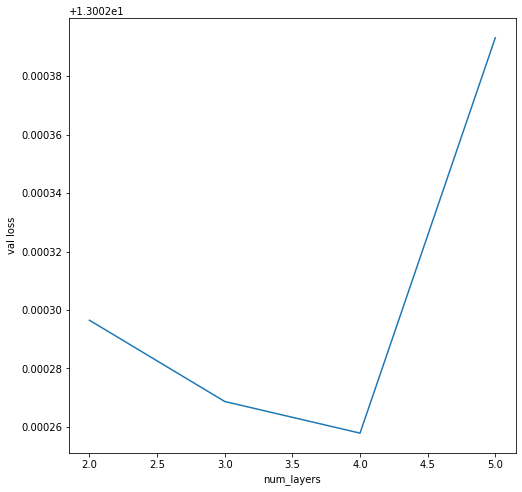

In [25]:
#plots for different hyperparameters
#layers
layersdic = {'def':2, '3layers':3, '4layers': 4, '5layers':5}
xaxis = list(map(lambda kvp: kvp[1], layersdic.items()))
yaxis = list(map(lambda kvp: lossdict[kvp[0]][0], layersdic.items()))
plt.figure(figsize = (8,8))
plt.plot(xaxis, yaxis)
plt.xlabel('num_layers')
plt.ylabel('val loss')
plt.show()

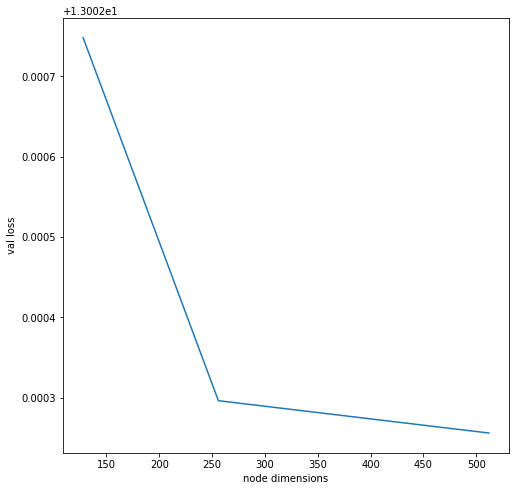

In [30]:
#plots for different hyperparameters
#node_dim
nodedimdic = {'nodedim128':128, 'def':256, 'nodedim512':512}
xaxis = list(map(lambda kvp: kvp[1], nodedimdic.items()))
yaxis = list(map(lambda kvp: lossdict[kvp[0]][0], nodedimdic.items()))
plt.figure(figsize = (8,8))
plt.plot(xaxis, yaxis)
plt.xlabel('node dimensions')
plt.ylabel('val loss')
plt.show()

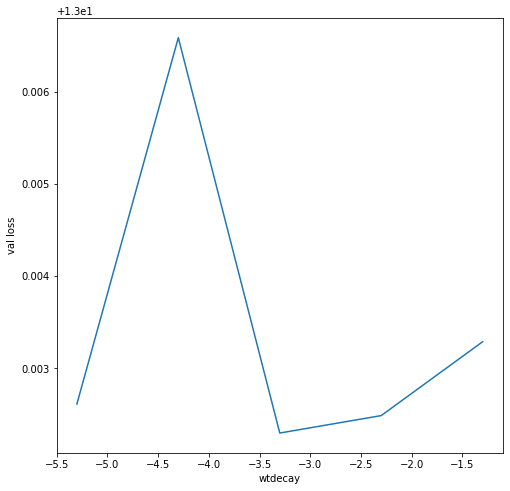

In [32]:
#plots for different hyperparameters
#wtdecay
wtdecaydic = {'2wtdecay':5e-2, '3wtdecay':5e-3, 'def':5e-4, '5wtdecay':5e-5, '6wtdecay':5e-6}
xaxis = np.log10(list(map(lambda kvp: kvp[1], wtdecaydic.items())))
yaxis = list(map(lambda kvp: lossdict[kvp[0]][0], wtdecaydic.items()))
plt.figure(figsize = (8,8))
plt.plot(xaxis, yaxis)
plt.xlabel('wtdecay')
plt.ylabel('val loss')
plt.show()

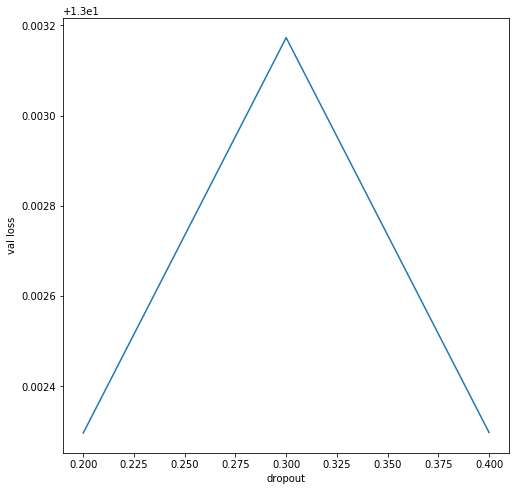

In [33]:
#plots for different hyperparameters
#drpout
drpoutdic = {'def':0.2, 'p3drpout':0.3, 'p4drpout':0.4}
xaxis = list(map(lambda kvp: kvp[1], drpoutdic.items()))
yaxis = list(map(lambda kvp: lossdict[kvp[0]][0], drpoutdic.items()))
plt.figure(figsize = (8,8))
plt.plot(xaxis, yaxis)
plt.xlabel('dropout')
plt.ylabel('val loss')
plt.show()

In [36]:
#See predictions
def predict(model, criterion, device, valid_graphs):
    model.eval()
    
    #validation phase
    with torch.set_grad_enabled(False):
        for i, val_graph in enumerate(valid_graphs):
            feats = val_graph.ndata['feat'].to(device)
            outputs = model(feats, val_graph)
            labels = val_graph.edata['feat']
            labels = labels.to(device)
            outputs = outputs[val_graph.edata['diff']]
            outputs = outputs.round().long()
            labels = labels[val_graph.edata['diff']]
            print("outputs: ")
            print(outputs)
            print("Actual labels")
            print(labels)

In [ ]:
#check predictions
checkpoint = torch.load(basicmodel, map_location=device)
hyperdic = checkpoint['hyperparams']
node_dim = hyperdic['node_dim']
n_layers = hyperdic['n_layers']
dropout = hyperdic['dropout']
wt_decay = hyperdic['wt_decay']
model = GCN(node_dim, node_dim, n_layers, F.relu, dropout)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.MSELoss()

test_graph = load_graphs(node_dim, data_path, True)[2]
predict(model, criterion, device, test_graph)

In [33]:
#analyze training data
from collections import Counter
cntr = Counter(train_graph.edata['feat'].reshape(-1).tolist())
cntr = dict(map(lambda kvp: (kvp[0], kvp[1]/sum(cntr.values())),cntr.items()))
cntr

/home/rj1408/miniconda3/envs/dgl_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/rj1408/miniconda3/envs/dgl_env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


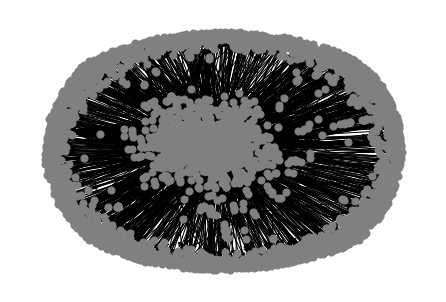

In [34]:
nx.draw(train_graph.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()